In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
using ODEInterfaceDiffEq
using Plots
using Measures
using CSV
using DataFrames
# using Turing
# using MCMCChains
using EasyFit
using StatsPlots
using LinearAlgebra
using Random
using Distributions
using LsqFit
using BlackBoxOptim
using LaTeXStrings
using JLD2
using BlackBoxOptim: num_func_evals
using LatinHypercubeSampling

# Load Model Functions

In [2]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\ModelFunctionsAll.jl")

ObjectFunctMERP (generic function with 1 method)

# Load Data and Pyruvate T1s

In [3]:
global dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
global dat128mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_12-8mMPyr_Dat.csv", DataFrame));

global datT1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\T1s.csv", DataFrame));

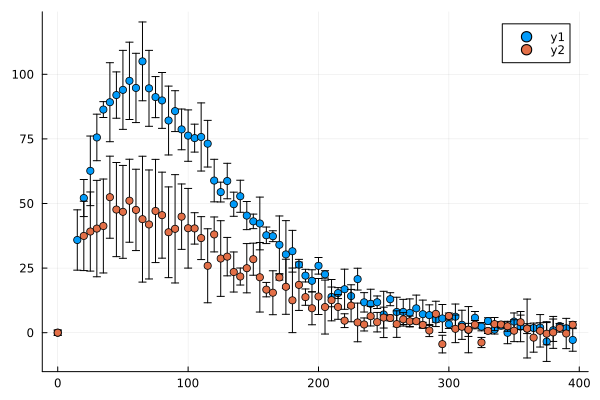

In [4]:
scatter(dat32mM[:,1], dat32mM[:,4], yerror=dat32mM[:,5])
scatter!(dat128mM[:,1], dat128mM[:,4], yerror=dat128mM[:,5])

# Define Models

In [28]:
# # Michaelis Menten

# function PyruvateHP_CellsRp!(du, u, p, t)

#     Pout, Php, Xhp, LDH, LDHP, LDHna, LDHPna = u;
#     T1_X, T1_P, kin, kpl, kf, kr, kf2, kr2 = p;


#     du[1] = dPout = - (Pout*kin) - (Pout/T1_P)
#     du[2] = dPhp = (Pout*kin) - (Php/T1_P) + kr*LDHP + kr2*LDHna + kr2*LDHPna - kf*LDH*Php - kf2*LDH*Php - kf2*LDHP*Php
#     du[3] = dXhp = - (Xhp/T1_X) + kpl*LDHP
#     du[4] = dLDH = kr*LDHP + kpl*LDHP + kr2*LDHna + kr2*LDHPna - kf*LDH*Php - kf2*LDH*Php
#     du[5] = dLDHP = kf*LDH*Php + kr2*LDHPna - kr*LDHP - kpl*LDHP - kf2*LDHP*Php
#     du[6] = dLDHna = kf2*LDH*Php - kr2*LDHna
#     du[7] = dLDHPna = kf2*LDHP*Php - kr2*LDHPna
    

# end



# Michaelis Menten

function PyruvateHP_CellsRp!(du, u, p, t)

    Pout, Php, Xhp, LDH, LDHP, LDHna, LDHPna, XhpHyper = u;
    T1_X, T1_P, kin, kpl, kf, kr, kf2, kr2 = p;


    du[1] = dPout = - (Pout*kin)
    du[2] = dPhp = (Pout*kin) + kr*LDHP + kr2*LDHna + kr2*LDHPna - kf*LDH*Php - kf2*LDH*Php - kf2*LDHP*Php
    du[3] = dXhp = kpl*LDHP
    du[4] = dLDH = kr*LDHP + kpl*LDHP + kr2*LDHna + kr2*LDHPna - kf*LDH*Php - kf2*LDH*Php
    du[5] = dLDHP = kf*LDH*Php + kr2*LDHPna - kr*LDHP - kpl*LDHP - kf2*LDHP*Php
    du[6] = dLDHna = kf2*LDH*Php - kr2*LDHna
    du[7] = dLDHPna = kf2*LDHP*Php - kr2*LDHPna
    

    du[8] = dXhpHyper =  dXhp - (XhpHyper/T1_X)

end

PyruvateHP_CellsRp! (generic function with 1 method)

In [29]:
function PyruvateHP_NMR_SolveAllRp(ts, pD, ivss, samps)


    nStat = 8;
    nPar = 8;

    if length(size(pD)) == 1
        pD = reshape(pD,size(pD)[1],1);
    end

    if size(pD)[2] != nPar     
        pD = pD';
    end

    if length(ivss)/nStat > 1
        if size(ivss)[2] != nStat
            ivss = ivss';
        end
    end

    AllSolTest = zeros(length(samps), nStat, length(pD[:,1])); # Simulation of the system observed
    AllSolTest_Off = Array{Any,1}(undef,length(pD[:,1])); # Simulation of the system before we obvserve it (considering time offset). First column is the time vector
    AllSolTest_Tog = Array{Any,1}(undef,length(pD[:,1])); # Previous two together. First column is the time vector. 


    
    for drawInd in collect(1:length(pD[:,1]))
        
        p = pD[drawInd,1:end-1];
        tau = pD[drawInd,end];
        
        if length(ivss)/nStat > 1
            ivss2 = ivss[drawInd,:];
        else
            ivss2 = ivss;
        end
    
        # Account for the time offset
    
        
            prob_off = ODEProblem(PyruvateHP_CellsRp!,ivss2,(-tau, 0),p);
            part1_off = DifferentialEquations.solve(prob_off, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9);
        
            ivss2 = part1_off.u[end];
        
            prob = ODEProblem(PyruvateHP_CellsRp!,ivss2,(ts[1], ts[end]),p);
            part1 = DifferentialEquations.solve(prob, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9,saveat=1);
        
        
        AllSolTest[:,:,drawInd]
    
        tmp = zeros(length(part1_off.u), nStat);
    
        
        

        for j in 1:nStat
            AllSolTest[:,j,drawInd] = [part1.u[i][j] for i in 1:length(part1.u)][samps.+1];
            tmp[:,j] = [part1_off.u[i][j] for i in 1:length(part1_off.u)];
        end

        AllSolTest_Off[drawInd] = hcat(part1_off.t, tmp);
        AllSolTest_Tog[drawInd] = vcat(AllSolTest_Off[drawInd][1:end-1, :], hcat(samps, AllSolTest[:,:,drawInd]));
        
        
        
    
    end

    return AllSolTest, AllSolTest_Off, AllSolTest_Tog

end

PyruvateHP_NMR_SolveAllRp (generic function with 1 method)

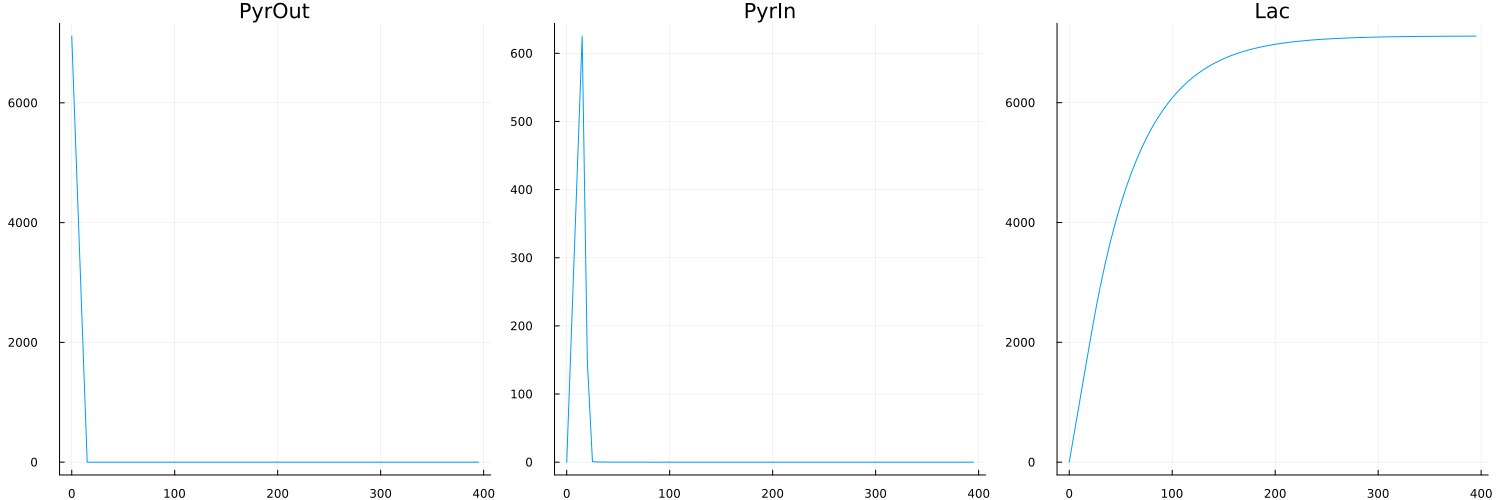

In [32]:
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2],0, dat32mM[1,4], 5000, 0, 0, 0, 0]; # Pout, Php, Xhp, LDH, LDHP, LDHna, LDHPna
samps = convert.(Int, tsC2);
pp = [48*1000000, 55*1000000, 0.0044*1000000, 0.02, 0.02, 0.001, 0, 0] # T1_X, T1_P, kin, kpl, kf, kr, kf2, kr2
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts, vcat(pp, 0), ivss, samps);

p1 = plot(tsC2, SimOnTime1[:,1,:], label = "", title = "PyrOut")
p2 = plot(tsC2, SimOnTime1[:,2,:], label = "", title = "PyrIn")
p3 = plot(tsC2, SimOnTime1[:,3,:], label = "", title = "Lac")

plot(p1, p2, p3, size=(1500,500), layout = (1,3))

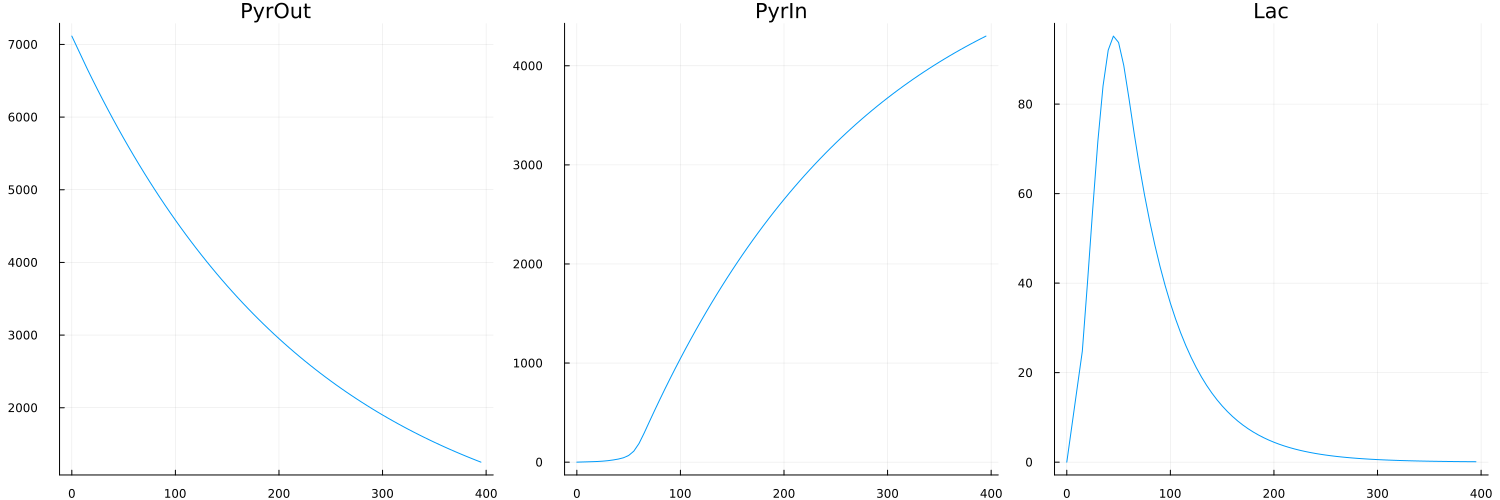

In [80]:
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2],0, dat32mM[1,4], dat32mM[1,2]/10, 0, 0, 0, 0]; # Pout, Php, Xhp, LDH, LDHP, LDHna, LDHPna
samps = convert.(Int, tsC2);
pp = [48, 55, 0.0044, 0.01, 0.02, 0.02, 0.002, 0.0002] # T1_X, T1_P, kin, kpl, kf, kr, kf2, kr2
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts, vcat(pp, 0), ivss, samps);

p1 = plot(tsC2, SimOnTime1[:,1,:], label = "", title = "PyrOut")
p2 = plot(tsC2, SimOnTime1[:,2,:], label = "", title = "PyrIn")
p3 = plot(tsC2, SimOnTime1[:,8,:], label = "", title = "Lac")

plot(p1, p2, p3, size=(1500,500), layout = (1,3))

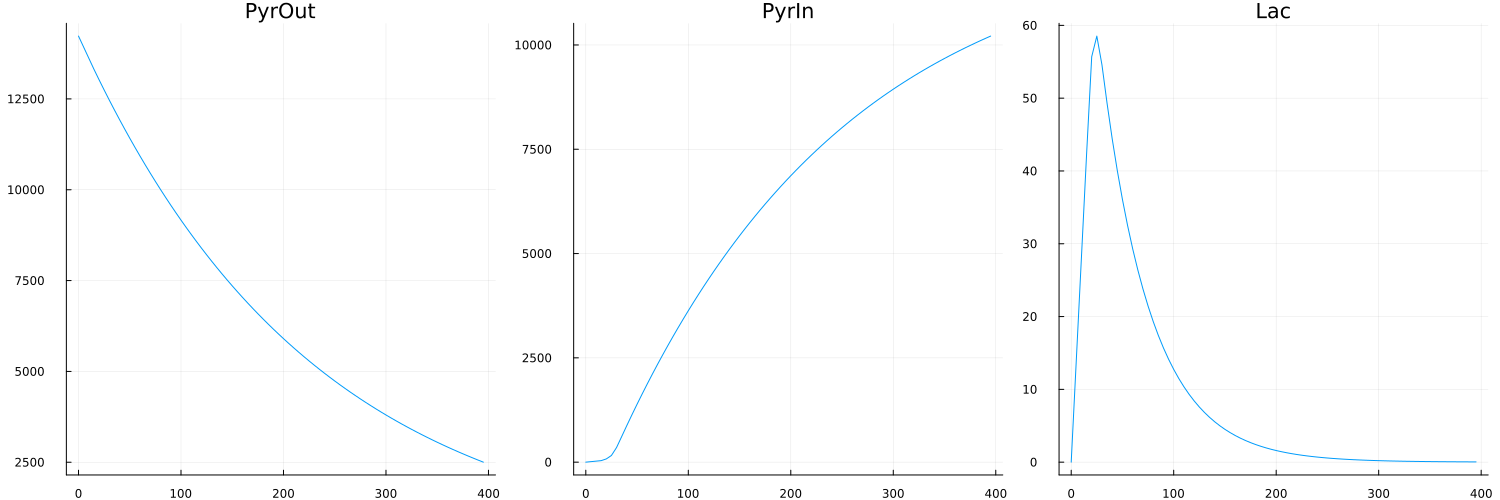

In [87]:
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2]*2,0, dat32mM[1,4], dat32mM[1,2]/10, 0, 0, 0, 0]; # Pout, Php, Xhp, LDH, LDHP, LDHna, LDHPna
samps = convert.(Int, tsC2);
pp = [48, 55, 0.0044, 0.01, 0.02, 0.02, 0.002, 0.0002] # T1_X, T1_P, kin, kpl, kf, kr, kf2, kr2
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts, vcat(pp, 0), ivss, samps);

p1 = plot(tsC2, SimOnTime1[:,1,:], label = "", title = "PyrOut")
p2 = plot(tsC2, SimOnTime1[:,2,:], label = "", title = "PyrIn")
p3 = plot(tsC2, SimOnTime1[:,8,:], label = "", title = "Lac")

plot(p1, p2, p3, size=(1500,500), layout = (1,3))

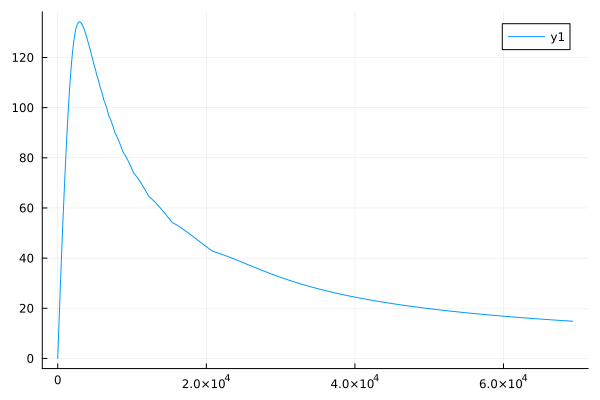

In [91]:
pyrs = collect(0:40:dat128mM[1,2]*2);
lacs = zeros(length(pyrs));

sims = Array{Any}(undef, length(pyrs))


pp = [48, 55, 0.0044, 0.01, 0.02, 0.02, 0.002, 0.0002]
cnt = 1;

for i in pyrs

    try
    tsC2 = dat32mM[:,1]
    ts = 0:tsC2[end];
    ivss = [i,0, dat32mM[1,4], dat32mM[1,2]/10, 0, 0, 0, 0];
    samps = convert.(Int, tsC2);
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts, vcat(vcat(pp), 0), ivss, samps);

    lacs[cnt] = maximum(SimOnTime1[:,8]);
    sims[cnt] = SimOnTime1;
    catch

    end
    cnt += 1;

end

plot(pyrs, lacs)

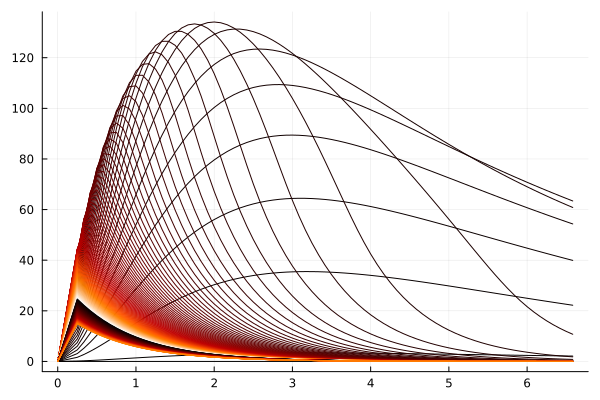

In [96]:
ps = plot(tsC2./60, sims[1][:,8,1], label = "", palette = :gist_heat) # Black low numbers, red middle, and white high
for i in 2:10:length(sims)
    plot!(tsC2./60, sims[i][:,8,1], label = "")
end

display(ps)

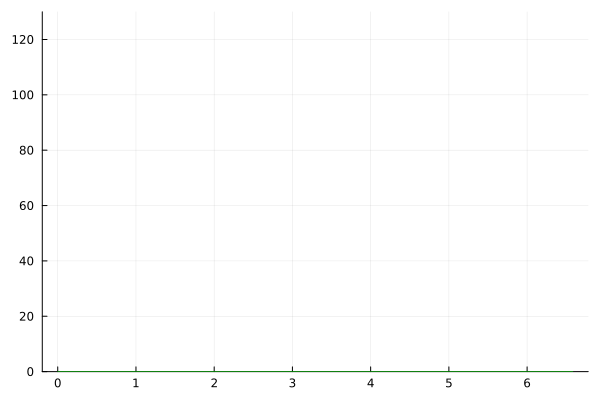

In [97]:
ps = plot(tsC2./60, sims[1][:,8,1], label = "", colour = "Green2", ylim = (0, 130)) # Black low numbers, red middle, and white high
savefig("C:\\IBECPostDocDrive\\2024_03_18_EUROMAR_Conference\\Videos\\Repress\\Sim"*string(1)*".png")
for i in 2:10:length(sims)
    plot(tsC2./60, sims[i][:,8,1], label = "", colour = "Green2", ylim = (0, 130))
    savefig("C:\\IBECPostDocDrive\\2024_03_18_EUROMAR_Conference\\Videos\\Repress\\Sim"*string(i)*".png")

end

display(ps)

# Fitting

In [306]:
function ObjectFunctMERp(p)

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(p[1:end-1], 0);

    # Define time vector
    t2cor = dat32mM[:,1];
    t4cor = dat128mM[:,1];

    # Define equaly-spaced time vector
    ts1 = collect(0:t2cor[end]);
    ts2 = collect(0:t4cor[end]);

    # Define initial value for simulation (use of experimental mean)
    ivss1 = [dat32mM[1,2], 0, dat32mM[1,4], p[end], 0, 0, 0, 0];
    ivss2 = [dat128mM[1,2], 0, dat128mM[1,4], p[end], 0, 0, 0, 0];

    # Convert sampling vector to integer to extract correct elements from simulation
    samps1 = convert.(Int, t2cor);
    samps2 = convert.(Int, t4cor);

    # Simulate
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts1, pD2, ivss1, samps1);
    SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllRp(ts2, pD2, ivss2, samps2);

    # Use of log-likelihood as cost funtion: J_llk = sum(-1/2 * (log(2*pi) + log(std^2) + (sim-dat)^2/std^2))
    # mm11 = sum((-1/2) .* (log(2*pi) .+ log.(dat32mM[:,3].^2) .+ (((SimOnTime1[:,1]+SimOnTime1[:,2]) .- dat32mM[:,2]).^2)./(dat32mM[:,3].^2)));
    # mm12 = sum((-1/2) .* (log(2*pi) .+ log.(dat128mM[:,3].^2) .+ (((SimOnTime2[:,1]+SimOnTime2[:,2]) .- dat128mM[:,2]).^2)./(dat128mM[:,3].^2)));

    mm21 = sum((-1/2) .* (log(2*pi) .+ log.(dat32mM[:,5].^2) .+ ((SimOnTime1[:,8] .- dat32mM[:,4]).^2)./(dat32mM[:,5].^2)));
    mm22 = sum((-1/2) .* (log(2*pi) .+ log.(dat128mM[:,5].^2) .+ ((SimOnTime2[:,8] .- dat128mM[:,4]).^2)./(dat128mM[:,5].^2)));


    # obj = (mm21+mm22)*(mm11+mm12);
    obj = -(mm21+mm22);

    
    return(obj)

end

ObjectFunctMERp (generic function with 1 method)

In [143]:
p = [48, 55, 0.0044, 0.01, 0.02, 0.02, 0.002, 0.0002, dat32mM[1,2]/10];

ObjectFunctMERp(p)

2306.496174393121

In [144]:
T1ss = vcat(datT1[1:5,2], datT1[7:11,2]);

In [145]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [105]:
Random.seed!(4879564)
plan = randomLHC(Iters,9)
initguessT = scaleLHC(plan,[(48, 48), (55, 55), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1e8)])

1×9 Matrix{Float64}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [ ]:
Threads.nthreads()

20

In [ ]:
[48, 55, 0.0044, 0.01, 0.02, 0.02, 0.002, 0.0002, dat32mM[1,2]/10]

In [307]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMERp; 
        SearchRange = [(48, 48), (55, 55), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, dat32mM[1,2])], # T1_X, T1_P, kin, kpl, kf, kr, kf2, kr2
        MaxTime = 60*5, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 59 evals, 33 steps, improv/step: 0.576 (last = 0.5758), fitness=858742.143061488
1.02 secs, 119 evals, 72 steps, improv/step: 0.472 (last = 0.3846), fitness=2549.343156343
1.52 secs, 181 evals, 118 steps, improv/step: 0.441 (last = 0.3913), fitness=2549.343156343
2.03 secs, 245 evals, 169 steps, improv/step: 0.408 (last = 0.3333), fitness=2549.343156343
2.54 secs, 305 evals, 220 steps, improv/step: 0.414 (last = 0.4314), fitness=2549.343156343
3.05 secs, 369 evals, 284 steps, improv/step: 0.408 (last = 0.3906), fitness=2549.343156343
3.56 secs, 434 evals, 348 steps, improv/step: 0.411 (last = 0.4219), fitness=2549.343156343
4.06 secs, 507 evals, 422 steps, improv/step: 0.382 (last = 0.2432), fitness=2042.661784322
4.56 secs, 583 evals, 501 steps, improv/step: 0.379 (last = 0

In [106]:
# Threads.@threads for i in 1:Iters
#     fitness_progress_history = Array{Tuple{Int, Float64},1}()
#     callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

#     resM = bboptimize(ObjectFunctMERp, initguessT[i,:]; SearchRange = [(48, 48), (55, 55), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1e8)], 
#             MaxTime = 60*0.1, method = :adaptive_de_rand_1_bin, 
#             CallbackFunction = callback, CallbackInterval = 0.0)

#     CCsT[i] = fitness_progress_history;
#     FitsT[i] = resM;
# end

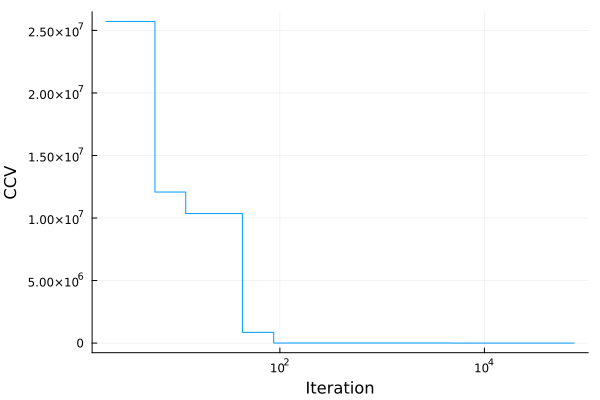

In [308]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
# for i in 2:length(CCsT)
#     plot!(CCsT[i], xaxis=:log, linetype=:step, label = "")
# end

display(pl)

In [309]:
parfitT = zeros(9, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end

In [310]:
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))

1

In [311]:
ppT = parfitT[:,bestPind]

9-element Vector{Float64}:
   48.0
   55.0
    0.040938600386957145
    0.01527272836065258
    6.518649748456401e-6
    0.19516445497711302
    1.0259843627635187e-5
    0.00017922101702295832
 7114.475321875807

In [312]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMTRRRP.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRRP.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [318]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRRP.jld2")["resMMat"][:,bestPind]


9-element Vector{Float64}:
   48.0
   55.0
    0.040938600386957145
    0.01527272836065258
    6.518649748456401e-6
    0.19516445497711302
    1.0259843627635187e-5
    0.00017922101702295832
 7114.475321875807

## Plot Results

In [296]:
pp = [48, 55, 0.0044, 0.01, 0.02, 0.02, 0.002, 0.0002]

8-element Vector{Float64}:
 48.0
 55.0
  0.0044
  0.01
  0.02
  0.02
  0.002
  0.0002

In [319]:
N=4
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2], 0, dat32mM[1,4], ppT[end], 0, 0, 0, 0];
samps = convert.(Int, tsC2);
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts, vcat(ppT[1:end-1], 0), ivss, samps);


tsC4 = dat128mM[:,1]
ts = 0:tsC4[end];
ivss = [dat128mM[1,2], 0, dat128mM[1,4], ppT[end], 0, 0, 0, 0];
samps = convert.(Int, tsC4);
SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllRp(ts, vcat(ppT[1:end-1], 0), ivss, samps);



([34670.694942714574 0.0 … 0.0 0.0; 15288.834584322161 12487.678345199554 … 785.7262246301773 115.32279508438788; … ; 0.00403639896072753 25954.435093590844 … 1328.0795195595467 1.4390960279308422; 0.0032892520126632505 25951.803836146682 … 1329.3793244956753 1.4323927724461873;;;], Any[[-0.0 34670.694942714574 … 0.0 0.0]], Any[[0.0 34670.694942714574 … 0.0 0.0; 20.0 15288.834584322161 … 785.7262246301773 115.32279508438788; … ; 390.0 0.00403639896072753 … 1328.0795195595467 1.4390960279308422; 395.0 0.0032892520126632505 … 1329.3793244956753 1.4323927724461873]])

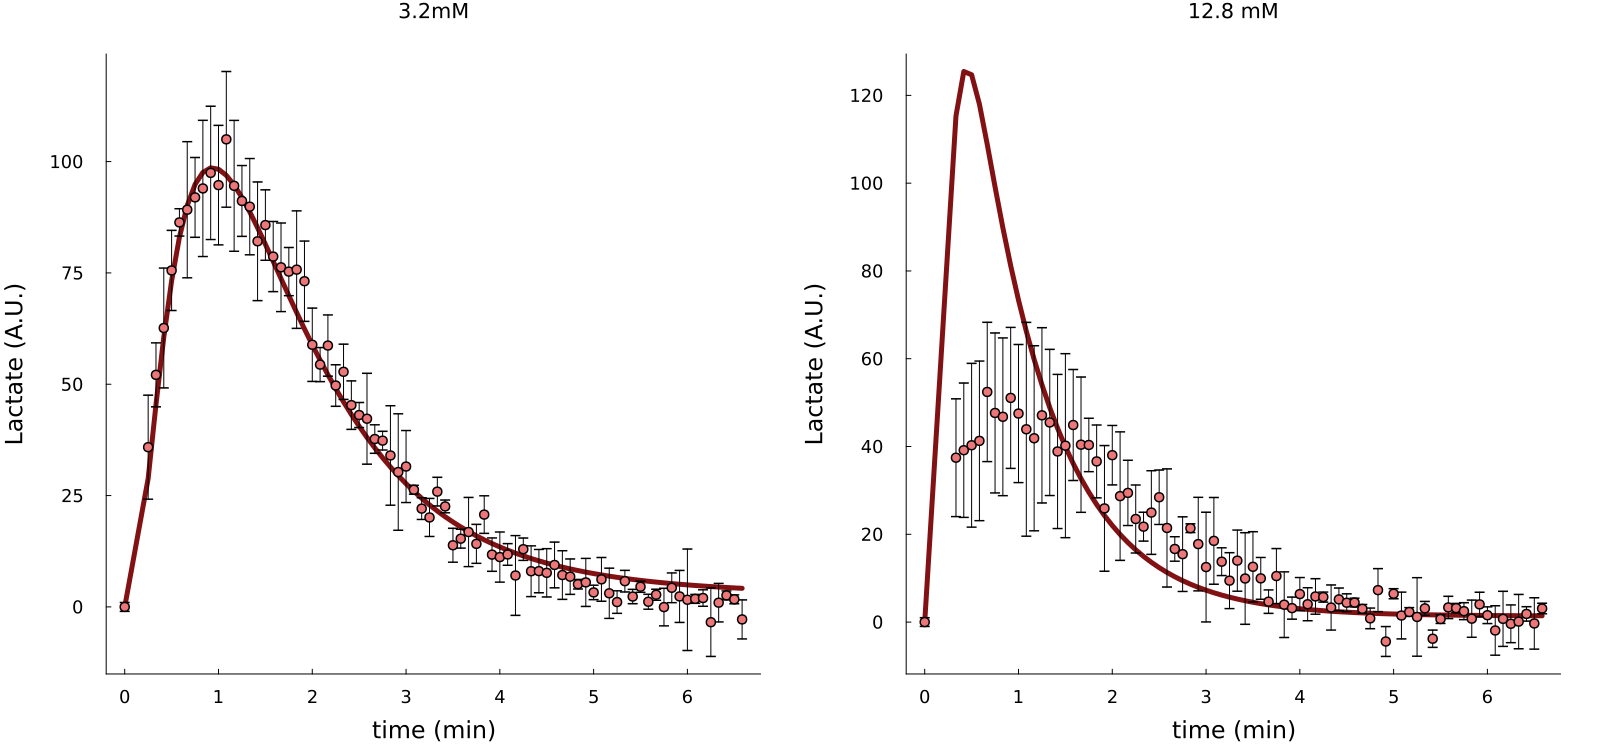

In [320]:
pp1 = plot(tsC2./60, SimOnTime1[:,1,1]+SimOnTime1[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "2 Mil")
scatter!(tsC2./60, dat32mM[:,2], yerror = dat32mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC2./60, SimOnTime1[:,8,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC2./60, dat32mM[:,4], yerror = dat32mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P1 = plot(pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12, title = "3.2mM")

pp1 = plot(tsC4./60, SimOnTime2[:,1,1]+SimOnTime2[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "4 Mil")
scatter!(tsC4./60, dat128mM[:,2], yerror = dat128mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC4./60, SimOnTime2[:,8,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC4./60, dat128mM[:,4], yerror = dat128mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P2 = plot(pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12, title = "12.8 mM")


pF = plot(P1,P2, layout=(1,2), size = (1600,750))


savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\SVGsInit\\PosteriorTestRepressFit.svg")


display(pF)

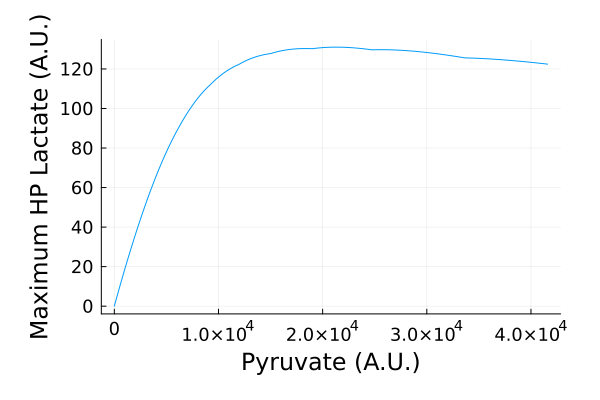

In [321]:
pyrs = collect(0:40:dat128mM[1,2]*1.2);
lacs = zeros(length(pyrs));
sims = Array{Any}(undef, length(pyrs))

cnt = 1;

for i in pyrs

    try
    tsC2 = dat32mM[:,1]
    ts = 0:tsC2[end];
    ivss = [i,0, dat32mM[1,4], ppT[end], 0, 0, 0, 0];
    samps = convert.(Int, tsC2);
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts, vcat(ppT[1:end-1], 0), ivss, samps);

    lacs[cnt] = maximum(SimOnTime1[:,8]);
    sims[cnt] = SimOnTime1;
    catch

    end
    cnt += 1;

end

pps = plot(pyrs, lacs, label = "", xlabel = "Pyruvate (A.U.)", ylabel = "Maximum HP Lactate (A.U.)", margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)

savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\SVGsInit\\PyrLacRatRepressionFit.svg")

display(pps)


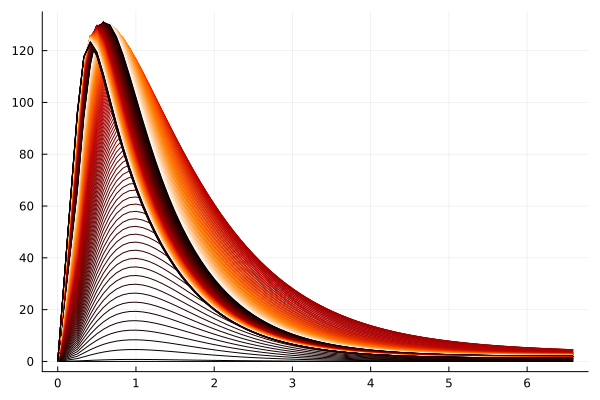

In [322]:
ps = plot(tsC2./60, sims[1][:,8,1], label = "", palette = :gist_heat) # Black low numbers, red middle, and white high
for i in 2:5:length(sims)
    plot!(tsC2./60, sims[i][:,8,1], label = "")
end

display(ps)

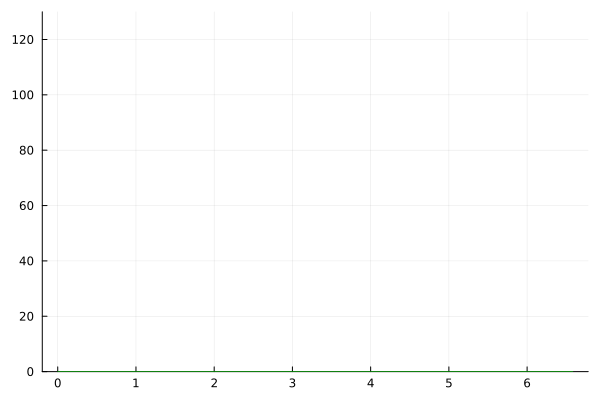

In [323]:
ps = plot(tsC2./60, sims[1][:,8,1], label = "", colour = "Green2", ylim = (0, 130)) # Black low numbers, red middle, and white high
savefig("C:\\IBECPostDocDrive\\2024_03_18_EUROMAR_Conference\\Videos\\RepressFit\\Sim"*string(1)*".png")
for i in 2:5:length(sims)
    plot(tsC2./60, sims[i][:,8,1], label = "", colour = "Green2", ylim = (0, 130))
    savefig("C:\\IBECPostDocDrive\\2024_03_18_EUROMAR_Conference\\Videos\\RepressFit\\Sim"*string(i)*".png")

end

display(ps)

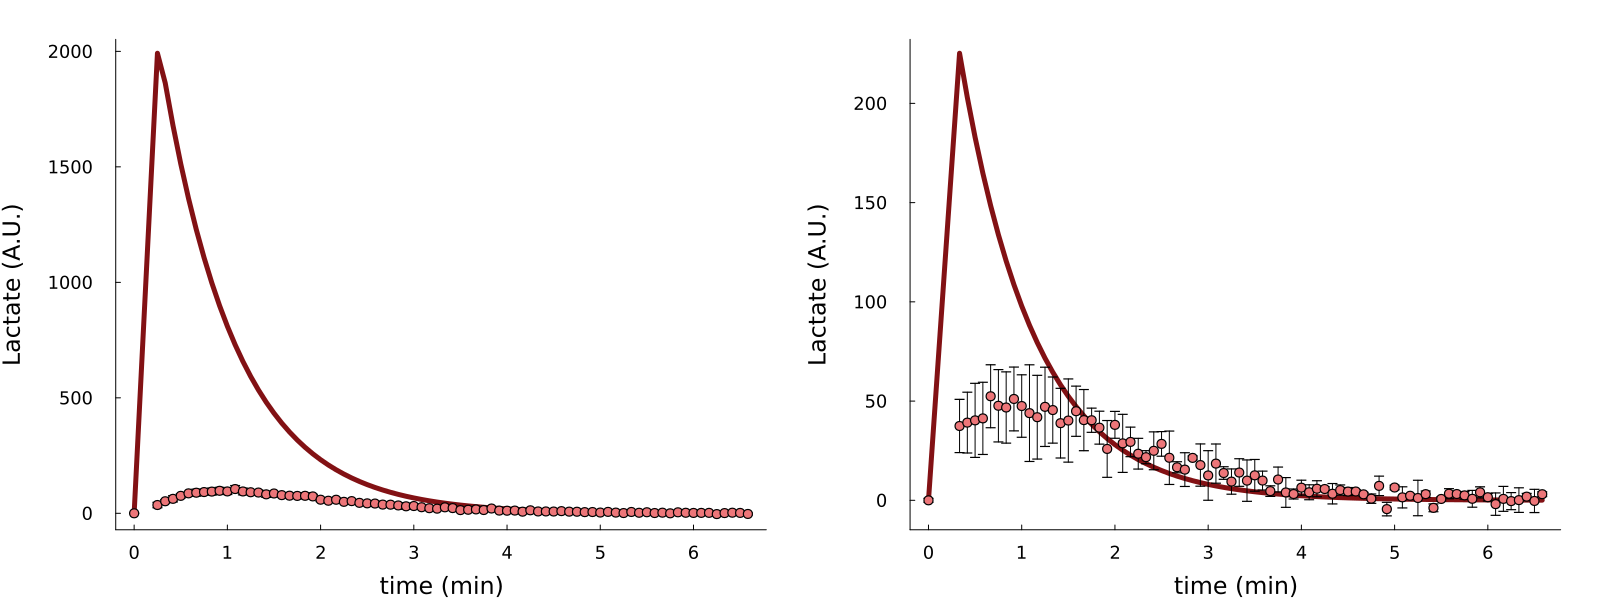

In [263]:
pp = [48, 55, 0.044, 0.8, 1e-1, 1e-8, 1e-2, 1e-8]
tsC2 = dat32mM[:,1];ts = 0:tsC2[end];;ivss = [dat32mM[1,2], 0, dat32mM[1,4], dat32mM[1,2]/10, 0, 0, 0, 0];
samps = convert.(Int, tsC2);;SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllRp(ts, vcat(pp, 0), ivss, samps);
tsC4 = dat128mM[:,1];ts = 0:tsC4[end];;ivss = [dat128mM[1,2], 0, dat128mM[1,4], dat32mM[1,2]/10, 0, 0, 0, 0];
samps = convert.(Int, tsC4);;SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllRp(ts, vcat(pp, 0), ivss, samps);
pp1 = plot(tsC2./60, SimOnTime1[:,1,1]+SimOnTime1[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "2 Mil")
scatter!(tsC2./60, dat32mM[:,2], yerror = dat32mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC2./60, SimOnTime1[:,8,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC2./60, dat32mM[:,4], yerror = dat32mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)
P1 = plot(pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)
pp1 = plot(tsC4./60, SimOnTime2[:,1,1]+SimOnTime2[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "4 Mil")
scatter!(tsC4./60, dat128mM[:,2], yerror = dat128mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)
pp2 = plot(tsC4./60, SimOnTime2[:,8,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC4./60, dat128mM[:,4], yerror = dat128mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)
P2 = plot(pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)
pF = plot(P1,P2, layout=(1,2), size = (1600,600))